# Stepwise reformulation of WDD for live processing

Goals:

- Allow computation of intermediate reconstruction results while data acquisition is still running
- Allow data-parallel implementation that scales to modern computer

In [1]:
%matplotlib nbagg
#%load_ext line_profiler

In [2]:
import tqdm
import tqdm.auto

In [3]:
import numpy as np
import scipy.ndimage

import matplotlib.pyplot as plt

In [4]:
from ptychography40.reconstruction.common import (
    wavelength, diffraction_to_detector, image_transformation_matrix, apply_matrix,
    fftshift_coords, ifftshift_coords, rolled_object_probe_product_cpu
)
from libertem.masks import circular

## Helper functions for testing

In [5]:
def allclose(a, b):
    # use the tolerances of `np.allclose` here:
    np.testing.assert_allclose(
        a,
        b,
        atol=1e-08,
        rtol=1e-05,
    )

## Define parameters for the initial simulation

Instead of measured data we use a simulation that is better suited to verify the calculation.

In [6]:
size = 32
semiconv = 0.087  # radian
lmbda = wavelength(300)  # 300 kV
pixel_size_real_sim = 0.5 * lmbda/size*256  # Simulate at high resolution
# One pixel in the diffracted space corresponds to the entire size in real space.
pixel_size_detector_sim = 1/size/pixel_size_real_sim*lmbda

In [7]:
lmbda, pixel_size_real_sim, pixel_size_detector_sim

(1.9687489006848795e-12, 7.874995602739518e-12, 0.0078125)

## Create an object

This object has low symmetry and contains a wave modulation, which leaves a characteristic signature in the diffraction pattern.

In [8]:
obj = np.ones((size, size), dtype=np.complex64)
y, x = np.ogrid[-size//2:size//2, -size//2:size//2]

outline = (((y*1.2)**2 + x**2) > (110/256*size)**2) & ((((y*1.2)**2 + x**2) < (120/256*size)**2))
obj[outline] = 0.0

left_eye = ((y + 40/256*size)**2 + (x + 40/256*size)**2) < (20/256*size)**2
obj[left_eye] = 0
right_eye = (np.abs(y + 40/256*size) < 15/256*size) & (np.abs(x - 40/256*size) < 30/256*size)
obj[right_eye] = 0

nose = (y + 20/256*size + x > 0) & (x < 0) & (y < 10/256*size)

obj[nose] = (0.05j * x + 0.05j * y)[nose]

mouth = (((y*1)**2 + x**2) > (50/256*size)**2) & ((((y*1)**2 + x**2) < (70/256*size)**2)) & (y > 20/256*size)

obj[mouth] = 0

tongue = (((y - 50/256*size)**2 + (x - 50/256*size)**2) < (20/256*size)**2) & ((y**2 + x**2) > (70/256*size)**2)
obj[tongue] = 0

# This wave modulation introduces a strong signature in the diffraction pattern
# that allows to confirm the correct scale and orientation.
signature_wave = np.exp(1j*(3 * y + 7 * x) * 2*np.pi/size)

obj += 0.3*signature_wave - 0.3

#obj = 0.99 + 0.01*obj

<IPython.core.display.Javascript object>


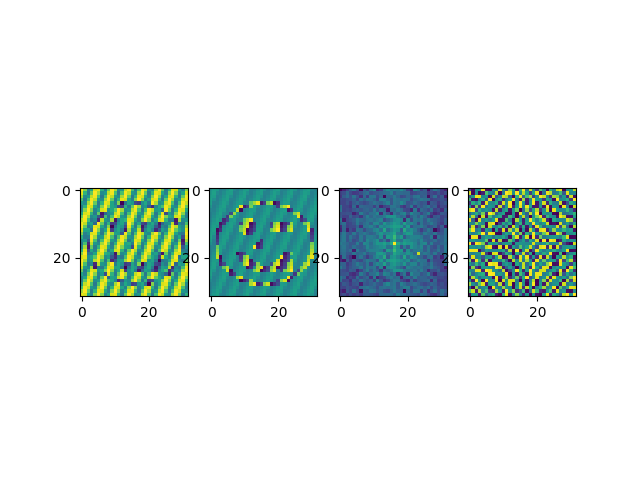

In [9]:
fig, axes = plt.subplots(1, 4)
axes[0].imshow(np.abs(obj))
axes[1].imshow(np.angle(obj))
axes[2].imshow(np.log1p(np.abs(np.fft.fftshift(np.fft.fft2(obj)))))
axes[3].imshow(np.angle(np.fft.fftshift(np.fft.fft2(obj))))

## Calculate the illumination

The illumination is first defined in radial space with a circular aperture, i.e. a convergent beam, as it is common in scanning transmission electron microscopy. It is then projected into the object plane using an inverse Fourier transform.

The `fftshift` takes care of proper shift to the center.

In [10]:
illum_radial = np.zeros((size, size), dtype=np.complex128)
#illum_radial[:] = np.exp(1j*(x**2 + y**2) / 5)
illum_radial[np.sqrt(y**2 + x**2) * pixel_size_detector_sim <= semiconv] = 17
# illum_radial[np.sqrt(y**2 + x**2) * pixel_size_detector_sim <= semiconv / 2] = 1j
#illum_radial[:] = np.random.random((size, size)) - 0.5 + 1j*np.random.random((size, size)) - 0.5j
#illum_radial *= 100

In [11]:
illum = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(illum_radial)))

<IPython.core.display.Javascript object>


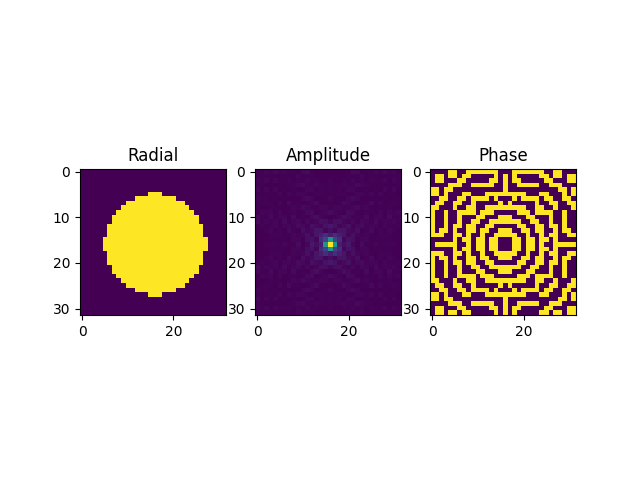

Text(0.5, 1.0, 'Phase')

In [12]:
fig, axes = plt.subplots(1, 3)
axes[0].imshow(np.abs(illum_radial))
axes[0].set_title("Radial")
axes[1].imshow(np.abs(illum))
axes[1].set_title("Amplitude")
axes[2].imshow(np.angle(illum))
axes[2].set_title("Phase")

## Forward simulation

Multiply the illumination with the object, project it to the far field and transform amplitude to intensity.

In [13]:
exitwave = illum * obj
projection = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(exitwave)))
diffpattern_sim = np.abs(projection)**2

<IPython.core.display.Javascript object>


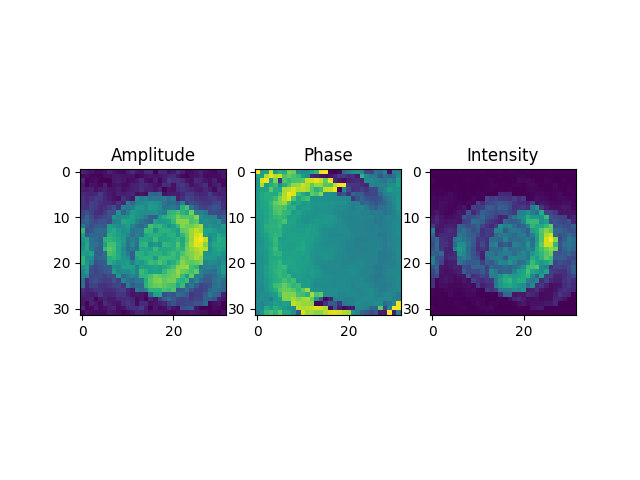

Text(0.5, 1.0, 'Intensity')

In [14]:
fig, axes = plt.subplots(1, 3)
axes[0].imshow(np.abs(projection))
axes[0].set_title("Amplitude")
axes[1].imshow(np.angle(projection))
axes[1].set_title("Phase")
axes[2].imshow(diffpattern_sim)
axes[2].set_title("Intensity")

## Simulated 4D STEM

In [15]:
data = np.zeros((size, size, size, size))
for y_shift in range(size):
    for x_shift in range(size):
        shifted_illum = np.roll(illum, (y_shift - size//2, x_shift - size//2), axis=(0, 1))
        projection = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift((obj * shifted_illum))))
        data[y_shift, x_shift] = np.abs(projection)**2

<IPython.core.display.Javascript object>


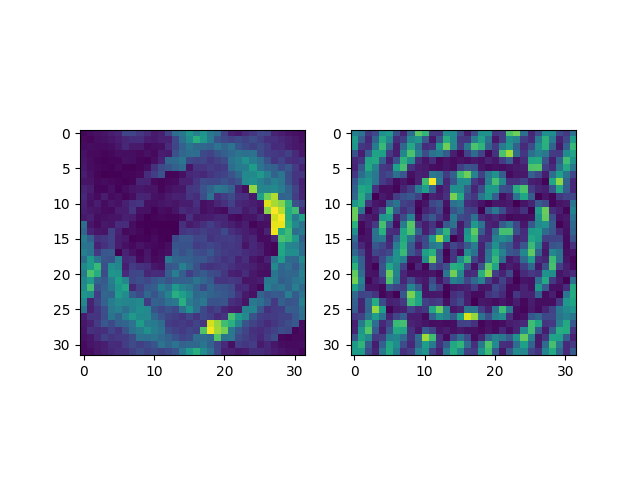

In [16]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(data[6, 23])
axes[1].imshow(data[:, :, size//2, size//2])

# 0) Original reference WDD implementation

In [17]:
def WDD(data, illu_radial, epsilon=0.01):
    WDD_Probe = np.zeros(data.shape, dtype=np.result_type(data, np.complex64))
    for scan_y_idx in range(data.shape[0]):
        for scan_x_idx in range(data.shape[1]):
            probe_function_n = np.roll(illu_radial, (scan_y_idx, scan_x_idx), axis=(0, 1))
            WDD_Probe[scan_y_idx, scan_x_idx] = np.fft.ifft2(illu_radial * np.conjugate(probe_function_n))

    data_4D_H = np.fft.fft2(np.fft.ifft2(data, axes=(2, 3)), axes=(0, 1))

    WDD_Obj =  WDD_Probe * data_4D_H / (np.abs(WDD_Probe)**2 + epsilon)
    data_4D_D = np.fft.fft2(WDD_Obj, axes=(2, 3))

    D00 = np.sqrt(data_4D_D[0, 0, 0, 0])
    obj_function = np.conj(np.fft.ifft2(data_4D_D[:, : , 0, 0]))/D00
    return obj_function

In [18]:
res_ref = WDD(data, illum_radial, epsilon=0.001)

<IPython.core.display.Javascript object>


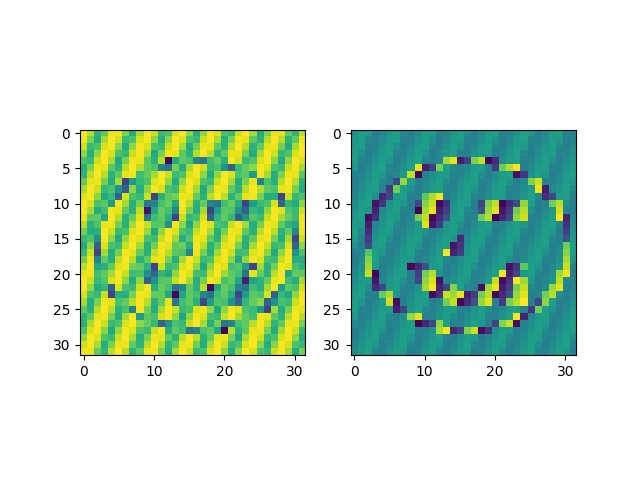

In [19]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(np.sqrt(np.abs(res_ref)))
axes[1].imshow(np.angle(res_ref))

# 1) Removal of the upfront FFT

Instead of using FFT to get the fourier transform, we can use an outer product with parts of a 2D fourier matrix:

## 3D FFT helpers

In [20]:
def matrix_2Dfourier(dim):
    """
    Method to generate 2D Fourier matrix
    """

    ## Load dimension

    F1 = np.fft.fft(np.eye(dim[0]))
    F2 = np.fft.fft(np.eye(dim[1]))
    Finv1 = np.fft.ifft(np.eye(dim[0]))
    Finv2 = np.fft.ifft(np.eye(dim[1]))

    F2D = np.kron(F1,F2)
    F2Dinv = np.kron(Finv1,Finv2)

    return F2D.astype(np.complex128), F2Dinv.astype(np.complex128)

In [21]:
F2D, _ = matrix_2Dfourier((data.shape[0], data.shape[1]))

In the live processing case, we don't have the whole of `data` available upfront - we can't simply use the FFT. Instead, we can calculate the contribution of each frame:

In [22]:
data_shape_flat = (data.shape[0] * data.shape[1], data.shape[2] * data.shape[3])
data_shape_flat

(1024, 1024)

In [23]:
data_4D_H_outer = np.zeros(
    data_shape_flat,
    dtype=np.complex128,
)
with tqdm.tqdm(total=data_shape_flat[0]) as pbar:
    for sy in range(data.shape[0]):
        for sx in range(data.shape[1]):
            frame = data[sy, sx]
            idx_flat = sx + sy * data.shape[1]

            # this frames' contribution to data_4D_H:
            data_4D_H_outer += np.outer(F2D[..., idx_flat], np.fft.ifft2(frame))
            pbar.update(1)

100%|█████████████████████████████████████████████████████████████████████████████████████████| 1024/1024 [00:05<00:00, 184.99it/s]


In [24]:
# for comparison, the original upfront fourier transform:
data_4D_H = np.fft.fft2(np.fft.ifft2(data, axes=(2, 3)), axes=(0, 1))
allclose(data_4D_H_outer.reshape((32, 32, 32, 32)), data_4D_H)

## Extract into a helper function

In [25]:
def get_frame_4D_H_contribution(F2D, frame, sy, sx, nav_shape):
    """
    This frames' contribution to all idp_rQ values as used in WDD
    """
    idx_flat = sx + sy * nav_shape[1]
    
    # Matrix multiplication A @ B is the same as the
    # sum of all outer products 
    return np.outer(F2D[..., idx_flat], np.fft.ifft2(frame))

In [26]:
def WDD_outer_product(data, illu_radial, epsilon=0.01):
    WDD_Probe = np.zeros(data.shape, dtype=np.result_type(data, np.complex64))
    for scan_y_idx in range(data.shape[0]):
        for scan_x_idx in range(data.shape[1]):
            probe_function_n = np.roll(illu_radial, (scan_y_idx, scan_x_idx), axis=(0, 1))
            WDD_Probe[scan_y_idx, scan_x_idx] = np.fft.ifft2(illu_radial * np.conjugate(probe_function_n))

    data_shape_flat = (data.shape[0] * data.shape[1], data.shape[2] * data.shape[3])
    data_4D_H = np.zeros(
        data_shape_flat,
        dtype=np.complex128,
    )
    for sy in range(data.shape[0]):
        for sx in range(data.shape[1]):
            frame = data[sy, sx]

            # this frames' contribution to data_4D_H:
            data_4D_H += get_frame_4D_H_contribution(F2D, frame, sy, sx, data.shape[:2])

    WDD_Obj = WDD_Probe * data_4D_H.reshape(data.shape) / (np.abs(WDD_Probe)**2 + epsilon)
    data_4D_D = np.fft.fft2(WDD_Obj, axes=(2, 3))

    D00 = np.sqrt(data_4D_D[0, 0, 0, 0])
    obj_function = np.conj(np.fft.ifft2(data_4D_D[:, : , 0, 0]))/D00
    return obj_function

In [27]:
np.allclose(
    res_ref,
    WDD_outer_product(data, illum_radial, epsilon=0.001),
)

True

# 1.5) Replace second-to-last FFT

We don't need to FFT just to get the zeor frequency, a sum is enough.

In [28]:
def zero_freq_equality():
    a = np.random.randn(16, 16, 16, 16)
    allclose(
        # in the original, we need to perform a FFT over two axes of the whole input data,
        # just to extract the zero frequency.
        np.fft.fft2(a, axes=(2, 3))[:, : , 0, 0],
    
        # this can be replaced with a sum:
        np.sum(a, axis=(2, 3)),
    )
zero_freq_equality()

In [29]:
def WDD_cut(data, illu_radial, epsilon=0.01):
    WDD_Probe = np.zeros(data.shape, dtype=np.result_type(data, np.complex64))
    for scan_y_idx in range(data.shape[0]):
        for scan_x_idx in range(data.shape[1]):
            probe_function_n = np.roll(illu_radial, (scan_y_idx, scan_x_idx), axis=(0, 1))
            WDD_Probe[scan_y_idx, scan_x_idx] = np.fft.ifft2(illu_radial * np.conjugate(probe_function_n))

    data_shape_flat = (data.shape[0] * data.shape[1], data.shape[2] * data.shape[3])
    data_4D_H = np.zeros(
        data_shape_flat,
        dtype=np.complex128,
    )
    for sy in range(data.shape[0]):
        for sx in range(data.shape[1]):
            frame = data[sy, sx]

            # this frames' contribution to data_4D_H:
            data_4D_H += get_frame_4D_H_contribution(F2D, frame, sy, sx, data.shape[:2])

    WDD_Obj = WDD_Probe * data_4D_H.reshape(data.shape) / (np.abs(WDD_Probe)**2 + epsilon)

    # NOTE: data_4D_D replaced here
    zero_freq = np.sum(WDD_Obj, axis=(2, 3))
    D00 = np.sqrt(zero_freq[0, 0])
    
    obj_function = np.conj(np.fft.ifft2(zero_freq))/D00
    return obj_function

In [30]:
allclose(
    res_ref,
    WDD_cut(data, illum_radial, epsilon=0.001),
)

# 2) Explicit looping

In [31]:
def WDD_explicit_loops(data, illu_radial, epsilon=0.01):
    WDD_Probe = np.zeros(data.shape, dtype=np.result_type(data, np.complex64))
    for scan_y_idx in range(data.shape[0]):
        for scan_x_idx in range(data.shape[1]):
            probe_function_n = np.roll(illu_radial, (scan_y_idx, scan_x_idx), axis=(0, 1))
            WDD_Probe[scan_y_idx, scan_x_idx] = np.fft.ifft2(illu_radial * np.conjugate(probe_function_n))

    data_shape_flat = (data.shape[0] * data.shape[1], data.shape[2] * data.shape[3])
    data_4D_H = np.zeros(
        data_shape_flat,
        dtype=np.complex128,
    )
    for sy in range(data.shape[0]):
        for sx in range(data.shape[1]):
            frame = data[sy, sx]

            # this frames' contribution to data_4D_H:
            data_4D_H += get_frame_4D_H_contribution(F2D, frame, sy, sx, data.shape[:2])

    WDD_Obj = np.zeros(data.shape, dtype=WDD_Probe.dtype)
    for sy in range(data.shape[0]):
        for sx in range(data.shape[1]):
            WDD_Probe_xy = WDD_Probe[sy, sx]
            WDD_Obj[sy, sx] = WDD_Probe_xy * data_4D_H.reshape(data.shape)[sy, sx] / (np.abs(WDD_Probe_xy)**2 + epsilon)

    # NOTE: data_4D_D replaced here
    zero_freq = np.sum(WDD_Obj, axis=(2, 3))
    D00 = np.sqrt(zero_freq[0, 0])
    
    obj_function = np.conj(np.fft.ifft2(zero_freq))/D00
    return obj_function

In [32]:
allclose(
    res_ref,
    WDD_explicit_loops(data, illum_radial, epsilon=0.001),
)

# 3) Merge loops

In [33]:
def WDD_merged(data, illu_radial, epsilon=0.01):
    WDD_Probe = np.zeros(data.shape, dtype=np.result_type(data, np.complex64))
    for scan_y_idx in range(data.shape[0]):
        for scan_x_idx in range(data.shape[1]):
            probe_function_n = np.roll(illu_radial, (scan_y_idx, scan_x_idx), axis=(0, 1))
            WDD_Probe[scan_y_idx, scan_x_idx] = np.fft.ifft2(illu_radial * np.conjugate(probe_function_n))

    data_shape_flat = (data.shape[0] * data.shape[1], data.shape[2] * data.shape[3])

    WDD_Obj = np.zeros(data.shape, dtype=WDD_Probe.dtype)
    for sy in range(data.shape[0]):
        for sx in range(data.shape[1]):
            frame = data[sy, sx]

            # this frames' contribution to data_4D_H:
            # the full array is no longer needed - only the contribution for a single frame
            data_4D_H = get_frame_4D_H_contribution(
                F2D, frame, sy, sx, data.shape[:2]
            ).reshape(data.shape)
            
            for sy_inner in range(data.shape[0]):
                for sx_inner in range(data.shape[1]):
            
                    WDD_Probe_xy = WDD_Probe[sy_inner, sx_inner]
                    WDD_Obj[sy_inner, sx_inner] += (
                        WDD_Probe_xy * data_4D_H.reshape(data.shape)[sy_inner, sx_inner]
                        / (np.abs(WDD_Probe_xy)**2 + epsilon)
                    )

    zero_freq = np.sum(WDD_Obj, axis=(2, 3))
    D00 = np.sqrt(zero_freq[0, 0])
    
    obj_function = np.conj(np.fft.ifft2(zero_freq))/D00
    return obj_function

In [34]:
allclose(
    res_ref,
    WDD_merged(data, illum_radial, epsilon=0.001),
)

# 4) Pre-compute the division

In the inner loop, we re-compute `WDD_Probe_xy / (np.abs(WDD_Probe_xy)**2 + epsilon)` for every frame of the dataset. This is not necessary, it can be pre-computed in the first loop that calculates `WDD_Probe`.

In [35]:
def WDD_more_precompute(data, illu_radial, epsilon=0.01):
    WDD_Probe = np.zeros(data.shape, dtype=np.result_type(data, np.complex64))
    for scan_y_idx in range(data.shape[0]):
        for scan_x_idx in range(data.shape[1]):
            probe_function_n = np.roll(illu_radial, (scan_y_idx, scan_x_idx), axis=(0, 1))
            probe = np.fft.ifft2(illu_radial * np.conjugate(probe_function_n))
            # NOTE: division folded into this loop
            WDD_Probe[scan_y_idx, scan_x_idx] = (
                probe / (np.abs(probe)**2 + epsilon)
            )
    data_shape_flat = (data.shape[0] * data.shape[1], data.shape[2] * data.shape[3])

    WDD_Obj = np.zeros(data.shape, dtype=WDD_Probe.dtype)
    for sy in range(data.shape[0]):
        for sx in range(data.shape[1]):
            frame = data[sy, sx]

            # this frames' contribution to data_4D_H:
            data_4D_H = get_frame_4D_H_contribution(
                F2D, frame, sy, sx, data.shape[:2]
            ).reshape(data.shape)
            
            for sy_inner in range(data.shape[0]):
                for sx_inner in range(data.shape[1]):
                    WDD_Probe_xy = WDD_Probe[sy_inner, sx_inner]
                    WDD_Obj[sy_inner, sx_inner] += (
                        WDD_Probe_xy * data_4D_H.reshape(data.shape)[sy_inner, sx_inner]
                    )

    zero_freq = np.sum(WDD_Obj, axis=(2, 3))
    D00 = np.sqrt(zero_freq[0, 0])
    
    obj_function = np.conj(np.fft.ifft2(zero_freq))/D00
    return obj_function

In [36]:
allclose(
    res_ref,
    WDD_more_precompute(data, illum_radial, epsilon=0.001),
)

# 5) Directly accumulate into the result

Now, we observe that in the end, we reduce `WDD_Obj` into its zero frequency by summation. This can be done beforehand - we don't need to materialize `WDD_Obj` in memory, which can be similar in size to the input data, or larger.

In [37]:
def WDD_accum(data, illu_radial, epsilon=0.01):
    WDD_Probe = np.zeros(data.shape, dtype=np.result_type(data, np.complex64))
    for scan_y_idx in range(data.shape[0]):
        for scan_x_idx in range(data.shape[1]):
            probe_function_n = np.roll(illu_radial, (scan_y_idx, scan_x_idx), axis=(0, 1))
            probe = np.fft.ifft2(illu_radial * np.conjugate(probe_function_n))
            WDD_Probe[scan_y_idx, scan_x_idx] = (
                probe / (np.abs(probe)**2 + epsilon)
            )

    data_shape_flat = (data.shape[0] * data.shape[1], data.shape[2] * data.shape[3])

    zero_freq = np.zeros(data.shape[:2], dtype=WDD_Probe.dtype)

    for sy in range(data.shape[0]):
        for sx in range(data.shape[1]):
            frame = data[sy, sx]

            # this frames' contribution to data_4D_H:
            data_4D_H = get_frame_4D_H_contribution(
                F2D, frame, sy, sx, data.shape[:2]
            ).reshape(data.shape)

            for sy_inner in range(data.shape[0]):
                for sx_inner in range(data.shape[1]):
                    WDD_Probe_xy = WDD_Probe[sy_inner, sx_inner]
                    # NOTE: no need to keep the full `WDD_Obj` around, directly reduce:
                    zero_freq[sy_inner, sx_inner] += (
                        np.sum(WDD_Probe_xy * data_4D_H.reshape(data.shape)[sy_inner, sx_inner])
                    )

    D00 = np.sqrt(zero_freq[0, 0])

    obj_function = np.conj(np.fft.ifft2(zero_freq))/D00
    return obj_function

In [38]:
allclose(
    res_ref,
    WDD_accum(data, illum_radial, epsilon=0.001),
)

# 6) Replace `F2D` matrix with row/col vectors

First, let's define a helper function to calculate just the row/column vectors instead of the whole `F2D` matrix:

In [39]:
def f2d_matrix_replacement(
    reconstruct_shape: 'Tuple',
    complex_dtype: 'nt.DTypeLike'
):
    """
    A Function to generate sampled Fourier basis, since we process the data
    per frame, it is better to use sampled Fourier basis not fft

    Parameters
    ----------
    shape
        Navigation shape of the dataset
    complex_dtype
        Pre defined data type of the elements

    Returns
    -------
    row_exp
        Sampled Fourier basis in terms of row dimension
    col_exp
        Sampled Fourier basis in terms of column dimension

    """
    row_steps = -2j*np.pi*np.linspace(0, 1, reconstruct_shape[0], endpoint=False)
    col_steps = -2j*np.pi*np.linspace(0, 1, reconstruct_shape[1], endpoint=False)
     
    full_y = reconstruct_shape[0]
    full_x = reconstruct_shape[1]

    # This creates a 2D array of row x spatial frequency
    row_exp = np.exp(
        row_steps[:,np.newaxis]
        * np.arange(full_y)[np.newaxis,:]
    )
    # This creates a 2D array of col x spatial frequency
    col_exp = np.exp(
        col_steps[:, np.newaxis]
        *np.arange(full_x)[np.newaxis, :]
    )
    # No normalization here to fit the reference result:
    return (
        row_exp.astype(complex_dtype),
        col_exp.astype(complex_dtype),
    )

In [40]:
def WDD_row_col_exp(data, row_exp, col_exp, illu_radial, epsilon=0.01):
    WDD_Probe = np.zeros(data.shape, dtype=np.result_type(data, np.complex64))
    for scan_y_idx in range(data.shape[0]):
        for scan_x_idx in range(data.shape[1]):
            probe_function_n = np.roll(illu_radial, (scan_y_idx, scan_x_idx), axis=(0, 1))
            probe = np.fft.ifft2(illu_radial * np.conjugate(probe_function_n))
            WDD_Probe[scan_y_idx, scan_x_idx] = (
                probe / (np.abs(probe)**2 + epsilon)
            )

    data_shape_flat = (data.shape[0] * data.shape[1], data.shape[2] * data.shape[3])

    zero_freq = np.zeros(data.shape[:2], dtype=WDD_Probe.dtype)

    for sy in range(data.shape[0]):
        for sx in range(data.shape[1]):
            frame = data[sy, sx]

            # the ifft2(frame) originally from `get_frame_4D_H_contribution`
            frame_ifft = np.fft.ifft2(frame)

            for sy_inner in range(data.shape[0]):
                for sx_inner in range(data.shape[1]):
                    WDD_Probe_xy = WDD_Probe[sy_inner, sx_inner]
                    
                    # spatial frequency factor:
                    exp_factor = row_exp[sy, sy_inner] * col_exp[sx, sx_inner]

                    acc = np.sum(WDD_Probe_xy * frame_ifft)
                    zero_freq[sy_inner, sx_inner] += exp_factor * acc

    D00 = np.sqrt(zero_freq[0, 0])

    obj_function = np.conj(np.fft.ifft2(zero_freq))/D00
    return obj_function

In [41]:
row_exp, col_exp = f2d_matrix_replacement(data.shape[:2], np.complex128)

allclose(
    res_ref,
    WDD_row_col_exp(data, row_exp, col_exp, illum_radial, epsilon=0.001),
)

In [42]:
res_rc = WDD_row_col_exp(data, row_exp, col_exp, illum_radial, epsilon=0.001)

<IPython.core.display.Javascript object>


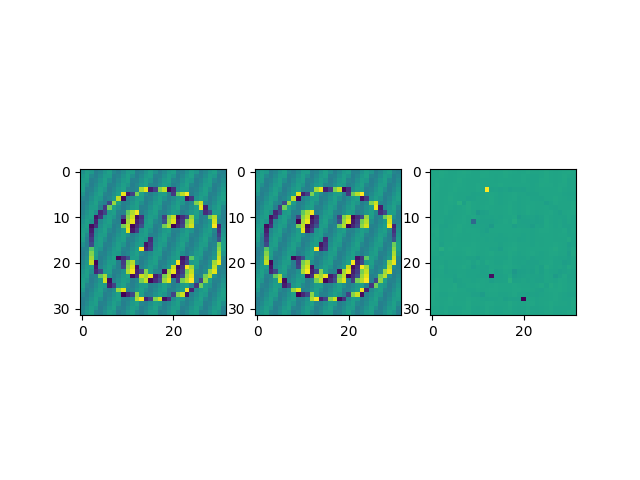

In [43]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.imshow(np.angle(res_ref))
ax2.imshow(np.angle(res_rc))
ax3.imshow(np.angle(res_rc) - np.angle(res_ref))

In [44]:
allclose(np.angle(res_ref), np.angle(res_rc))

<IPython.core.display.Javascript object>


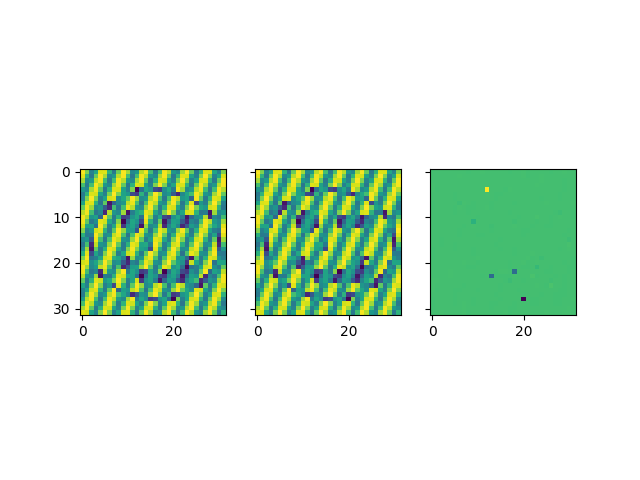

In [45]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True, sharey=True)
ax1.imshow(np.abs(res_ref))
ax2.imshow(np.abs(res_rc))
ax3.imshow(np.abs(res_rc) / np.abs(res_ref))

In [46]:
1 / np.mean(np.abs(res_rc) / np.abs(res_ref))

1.000000000000003